Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [35]:
#importing important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [36]:
##mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [37]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [38]:
#counting no of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('No of Training images =', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('No of Testing Images =', image_count_test)

No of Training images = 2239
No of Testing Images = 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [39]:
#default pixel and batch size
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [40]:
##creating a tensor data of image using a keras library
## using batch size 32 and seed=123 and resizing the image for training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "training",
    
)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [41]:
## using seed=123 and resizing the image for validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [42]:
## resizing test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [43]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

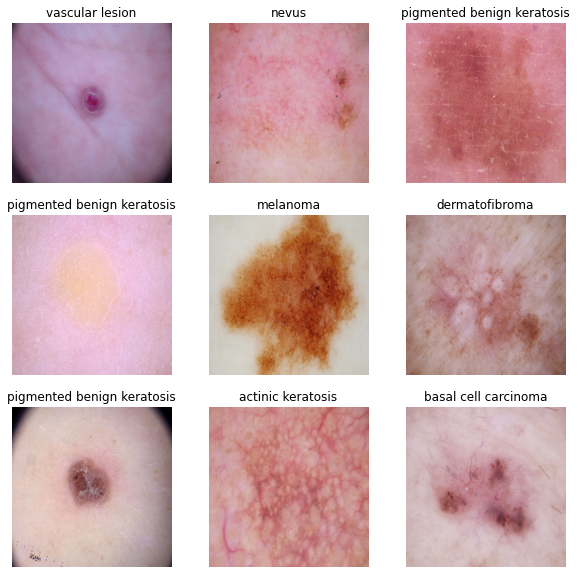

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        temp = labels[i].numpy()
        xr = (np.argmax(temp))
        plt.title(class_names[xr])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [45]:
#providing cache memory
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [46]:
### Building a model without dropout and normalization

input_shape = (180,180,3)
num_classes = 9
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dense(num_classes))
model.add(Activation("softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [47]:
### compiling the model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 89, 89, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        36928     
                                                      

### Train the model

In [49]:
#Training the model for 20epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 140ms/step - loss: 2.2493 - accuracy: 0.2199 - val_loss: 2.0054 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 5s 90ms/step - loss: 1.8224 - accuracy: 0.3432 - val_loss: 1.7383 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6613 - accuracy: 0.4202 - val_loss: 1.6082 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6004 - accuracy: 0.4286 - val_loss: 1.6240 - val_accuracy: 0.4340
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.5510 - accuracy: 0.4520 - val_loss: 1.5283 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4498 - accuracy: 0.4855 - val_loss: 1.4901 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.4544 - accuracy: 0.4810 - val_loss: 1.5955 - val_accuracy: 0.4676
Epoch 8/20


### Visualizing training results

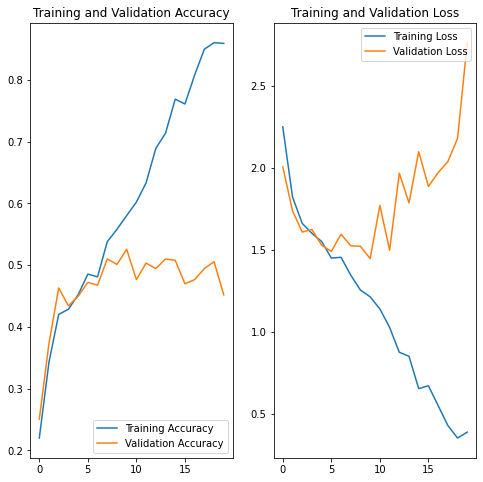

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Findings:
- The Training accuracy comes as 85.94
- The validation accuracy comes as 45.19
- Hence it is a clear case of __overfitting__ where the model does not work well on validation data

## Data Augmentation 

In [51]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

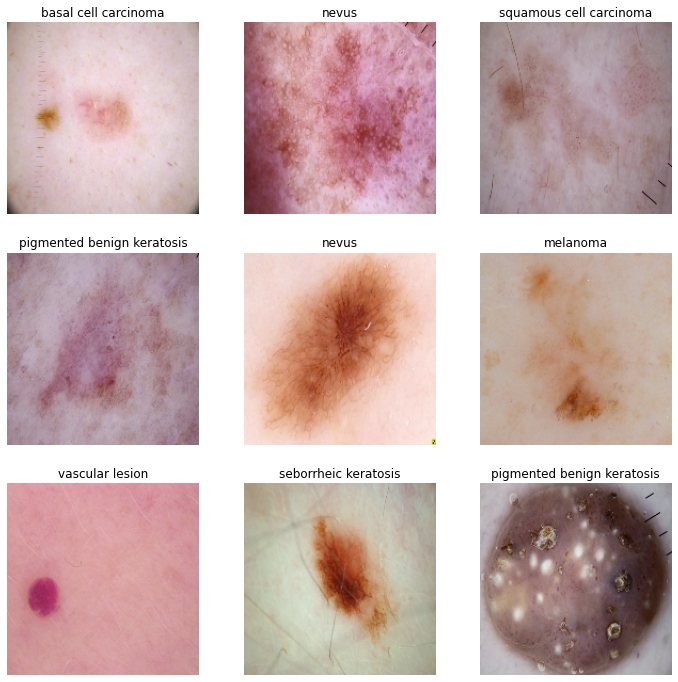

In [52]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        temp = labels[i].numpy()
        xr = (np.argmax(temp))
        plt.title(class_names[xr])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [53]:
## using Dropout layer and few other hyperparameters, since we had an evidence of overfitting


model = Sequential()

#adding the data augmentation layer 
model.add(data_aug)

#rescaling layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


### Compiling the model

In [54]:
## compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                      

### Training the model

In [55]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 97ms/step - loss: 2.3883 - accuracy: 0.2327 - val_loss: 1.9110 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.7901 - accuracy: 0.3560 - val_loss: 1.7609 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6923 - accuracy: 0.3862 - val_loss: 1.7221 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6994 - accuracy: 0.3912 - val_loss: 1.5832 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6360 - accuracy: 0.4079 - val_loss: 1.6338 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6503 - accuracy: 0.4191 - val_loss: 1.5943 - val_accuracy: 0.4698
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6548 - accuracy: 0.4263 - val_loss: 1.5186 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing the results

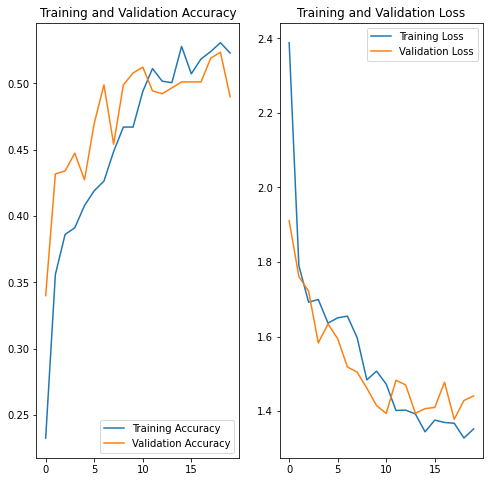

In [56]:
#visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings:**
*The training accuracy comes around 52% and the validation accuracy comes around 49%, The training and validtion accuracy are closely aligned,there is no sign of overfitting but the accuracy is very low, we need to improve the accuracy.*

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

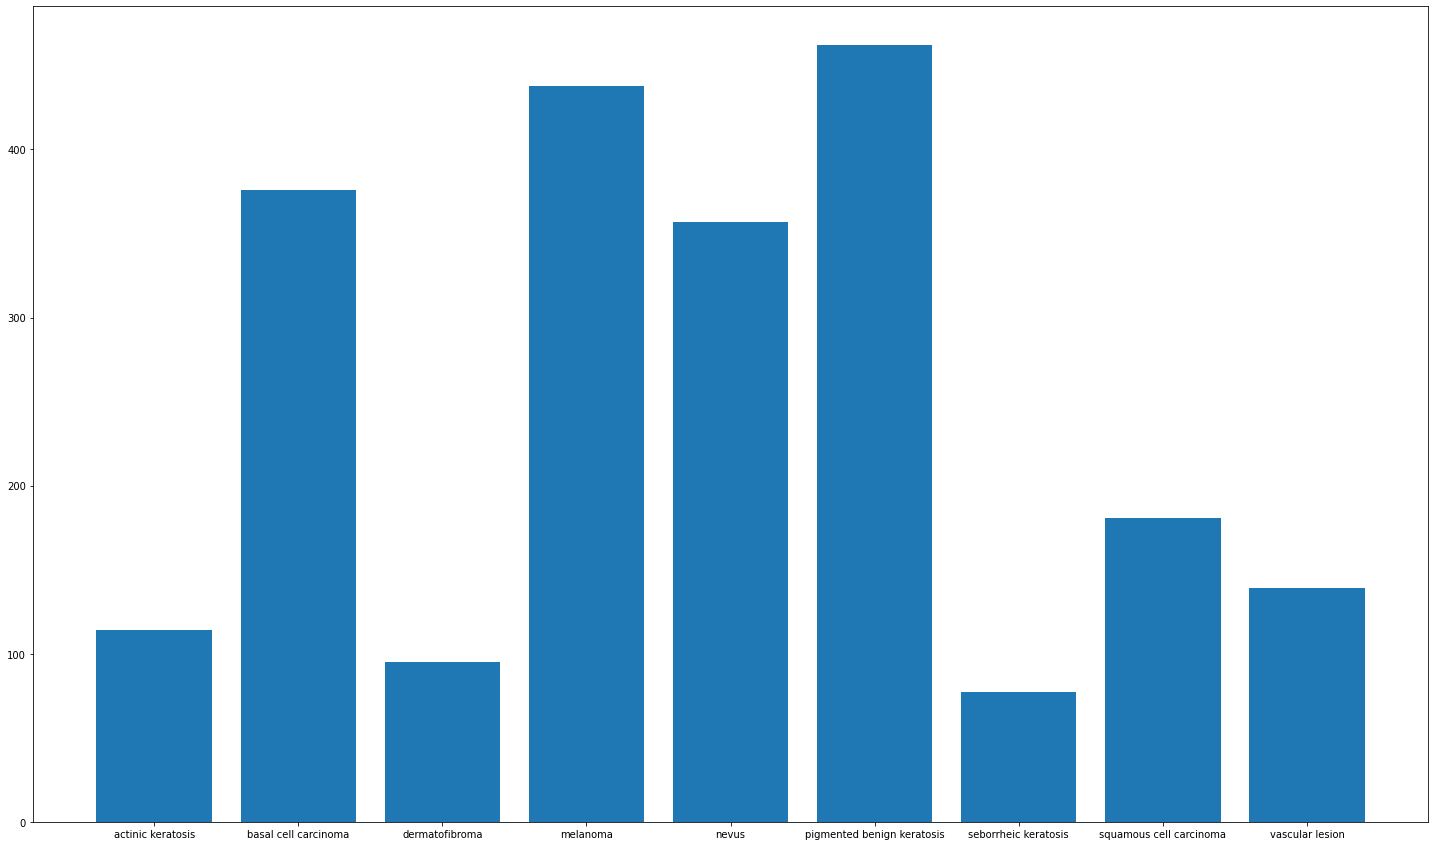

In [57]:
#creating a dataframe and visualizing all classes
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,15))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - **Which class has the least number of samples?**
  Seborrheic keratosis is having the lowest distribution
#### - **Which classes dominate the data in terms proportionate number of samples?**
  Pigmented Benign keratosis is having the highest distribution of data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [58]:
#installing Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [59]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAB3152C8D0>: 100%|██████████| 500/500 [00:20<00:00, 24.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAB20088450>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA9EEB8E90>: 100%|██████████| 500/500 [00:21<00:00, 22.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FAAB22A1110>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAAB2086350>: 100%|██████████| 500/500 [01:19<00:00,  6.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAAB2254C50>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAA9EF6CFD0>: 100%|██████████| 500/500 [00:41<00:00, 12.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAB2F689290>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA5BDB6990>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [60]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_2e594960-2363-4221-9338-5f3e4e9f8119.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_701ef8ef-7ed3-41b8-a205-b3ced3136ccc.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_9a410dab-bb9b-4a70-8db5-12be46487a09.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_cccd0b6a-3141-4130-8da8-50462271d5fb.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_168f2783-f4ea-4b83-8733-c36675096036.jpg',
 '/content/gdrive/My

In [62]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [63]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [64]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [65]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [66]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [67]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/assignment_dataset/melanoma_dataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "training",
    
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [68]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [74]:
#building model with both dropot and normalization in each layer and dropout at end of FC

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [75]:
## compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

## Model Summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)      

#### **Todo:**  Train your model

In [76]:
#Training for 30 epochs
epochs = 30

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 35s 196ms/step - loss: 3.6967 - accuracy: 0.3448 - val_loss: 6.6939 - val_accuracy: 0.1262
Epoch 2/30
169/169 [==============================] - 33s 190ms/step - loss: 1.3880 - accuracy: 0.4941 - val_loss: 2.4148 - val_accuracy: 0.3719
Epoch 3/30
169/169 [==============================] - 33s 189ms/step - loss: 1.1584 - accuracy: 0.5773 - val_loss: 1.3640 - val_accuracy: 0.5687
Epoch 4/30
169/169 [==============================] - 33s 191ms/step - loss: 1.0164 - accuracy: 0.6319 - val_loss: 1.6523 - val_accuracy: 0.5657
Epoch 5/30
169/169 [==============================] - 33s 190ms/step - loss: 0.8527 - accuracy: 0.6877 - val_loss: 0.7804 - val_accuracy: 0.7476
Epoch 6/30
169/169 [==============================] - 33s 193ms/step - loss: 0.7797 - accuracy: 0.7294 - val_loss: 1.6981 - val_accuracy: 0.5724
Epoch 7/30
169/169 [==============================] - 34s 193ms/step - loss: 0.6641 - accuracy: 0.7572 - val_loss: 0.8263 - val_ac

#### **Todo:**  Visualize the model results

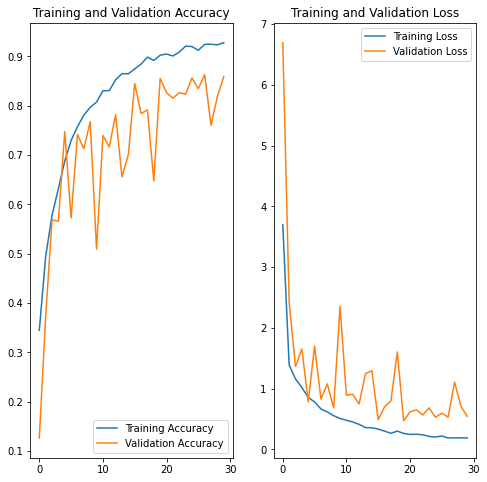

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- The class rebalance helped in reducing overfititng of the data and thus the 
loss is being reduced, and also the accuracy has increased very well
    - Training Accuracy = 92%
    - Validation Accuracy - 86%

- Initially for Model 1 we tried without dropout and no augmentation which created data to overfit at high ratio

- Then for Model 2 we introduced dropout and Augmentation which reduced overfitting

- At last we tried Batch Normalization and Augumentation which provided good results and best accuracy when compared to all 3